#   

# 作業目標:

    1. 藉由固定的 dataset, 來驗證不同loss function
    2. Dataset 的特性跟我們選用的loss function 對accrancy 的影響
    
    
# 作業重點: 
    請分別選用 "MSE", "binary _crossentropy"
    查看Train/test accurancy and loss rate
    

# 導入必要的函數

In [1]:
from keras.datasets import cifar10
import numpy as np
np.random.seed(10)# np.random.seed(10)的作用：使得隨機數據可預測

Using TensorFlow backend.


# 資料準備

In [2]:
# 取得Keras Dataset
# 匯入mnist模組用以下載並讀取mnist資料，利用mnist.load_data()下載資料
(x_img_train,y_label_train),(x_img_test,y_label_test)=cifar10.load_data()

In [3]:
# 確認 CIFAR10 Dataset 資料維度
print("train data:",'images:',x_img_train.shape,
      " labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ,
      " labels:",y_label_test.shape) 
'''
將x_img_train及x_img_test由原本三維轉為四維矩陣以符合CNN的需求，
這是因為RGB圖片的格式為為width, height, channels，加上ID數維度為4，
轉換後的shape為(ID, width, height, channel)
'''

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


'\n將x_img_train及x_img_test由原本三維轉為四維矩陣以符合CNN的需求，\n這是因為RGB圖片的格式為為width, height, channels，加上ID數維度為4，\n轉換後的shape為(ID, width, height, channel)\n'

In [4]:
# 資料正規化, 並設定 data array 為浮點數
# 圖像數值原本是0到255，將數值除以255，可以使數值介於0到1，除了可提昇模型預測的準確度，梯度運算時也能更快收斂。
# 將features標準化
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

In [5]:
# 針對Label 做 ONE HOT ENCODE, 並查看維度資訊
# 彼此間不相關且非有序的categories轉換為連續性且是有序數值。
# labe以one-hot encoding轉換
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(y_label_train)
y_label_test_OneHot = np_utils.to_categorical(y_label_test)
y_label_test_OneHot.shape

(10000, 10)

# 建立模型

## 1.建立模型(Model)：
首先，我們要確立Input格式、要經過幾層處理、每一層要作甚麼處理，例如以下程式：

##### 參考來源:https://ithelp.ithome.com.tw/articles/10191725

In [6]:
# 建立多層感知器的模型，先匯入需要用到的模組
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

In [7]:
# 宣告採用序列模型
# 建立一個線性堆疊的模型
model = Sequential()
'''
說明:
依據官方文件 說明，Keras 提供兩種模型，
Sequential Model (順序式模型)與 Functional API。

1.Sequential Model (順序式模型)：
就是一種簡單的模型，單一輸入、單一輸出，
按順序一層(Dense)一層的由上往下執行。
2.Functional API：支援多個輸入、多個輸出。
'''

'\n說明:\n依據官方文件 說明，Keras 提供兩種模型，\nSequential Model (順序式模型)與 Functional API。\n\n1.Sequential Model (順序式模型)：\n就是一種簡單的模型，單一輸入、單一輸出，\n按順序一層(Dense)一層的由上往下執行。\n2.Functional API：支援多個輸入、多個輸出。\n'

## 卷積層1

In [8]:
# 建構輸入層
# 建立第一個卷積層並加入model
model.add(Conv2D(filters=32, # 建立32個濾鏡filter weight
                 kernel_size=(3,3), # 每一個濾鏡3x3大小
                 input_shape=(32, 32,3),  # 輸入資料尺寸
                 activation='relu',  # 設定ReLu激活函數
                 padding='same')) # 設定卷積運算，產生的卷積影像大小不變
'''
參數說明:
filters: 該層有32個filters（即我們稱的filter或kernel）。
kernel_size: kernel大小為3 x 3 。
input_shape: 輸入的圖形維度為32 x 32 x 3 。
啟動函數: 'relu' 。
padding:'same' 代表保留邊界處的捲積結果，卷積後的圖形大小不變(即圖像周圍會補值)，通常會導致輸出shape與輸入shape相同。
padding:'valid' 代表只進行有效的捲積，對邊界數據不處理。
'''

"\n參數說明:\nfilters: 該層有32個filters（即我們稱的filter或kernel）。\nkernel_size: kernel大小為3 x 3 。\ninput_shape: 輸入的圖形維度為32 x 32 x 3 。\n啟動函數: 'relu' 。\npadding:'same' 代表保留邊界處的捲積結果，卷積後的圖形大小不變(即圖像周圍會補值)，通常會導致輸出shape與輸入shape相同。\npadding:'valid' 代表只進行有效的捲積，對邊界數據不處理。\n"

In [9]:
# 加入Dropout層，Dropout它最大的功用是減少過度擬合。
'''
在深度學習的訓練過程中，
Dropout會讓每次batch run都依據機率丟棄一定比例的神經元不予計算，
使得每一次都好像在訓練不同的神經網路一樣。
'''
model.add(Dropout(rate=0.25)) # 該Dropout層每次訓練時要丟棄25%的神經元。

In [10]:
# 建立池化層1
# 將32個28x28影像，縮小成32個14x14影像
model.add(MaxPooling2D(pool_size=(2, 2)))
'''
參數說明:
pool size: 定義為(2,2)，即尺寸縮小為一半
本層接收了第一個卷積層的32個28×28影像後，會輸出32個14×14的影像。
'''

'\n參數說明:\npool size: 定義為(2,2)，即尺寸縮小為一半\n本層接收了第一個卷積層的32個28×28影像後，會輸出32個14×14的影像。\n'

## 卷積層2與池化層2

In [11]:
# 建立第二個卷積層
model.add(Conv2D(filters=64,# 建立64個濾鏡
                 kernel_size=(3, 3), # 每一個濾鏡大小3x3
                 activation='relu',  # 設定ReLu激活函數
                 padding='same')) # 讓卷積運算部會改變影像大小
'''
參數說明:
filters: 該層有64個filters（即我們稱的filter或kernel）。
kernel_size: kernel大小為3 x 3 。
啟動函數: 'relu' 。
padding:'same' 代表保留邊界處的捲積結果，卷積後的圖形大小不變(即圖像周圍會補值)，通常會導致輸出shape與輸入shape相同。
padding:'valid' 代表只進行有效的捲積，對邊界數據不處理。
'''

"\n參數說明:\nfilters: 該層有64個filters（即我們稱的filter或kernel）。\nkernel_size: kernel大小為3 x 3 。\n啟動函數: 'relu' 。\npadding:'same' 代表保留邊界處的捲積結果，卷積後的圖形大小不變(即圖像周圍會補值)，通常會導致輸出shape與輸入shape相同。\npadding:'valid' 代表只進行有效的捲積，對邊界數據不處理。\n"

In [12]:
# 加入Dropout層，Dropout它最大的功用是減少過度擬合。
model.add(Dropout(0.25)) # 該Dropout層每次訓練時要丟棄25%的神經元。
'''
在深度學習的訓練過程中，
Dropout會讓每次batch run都依據機率丟棄一定比例的神經元不予計算，
使得每一次都好像在訓練不同的神經網路一樣。
'''

'\n在深度學習的訓練過程中，\nDropout會讓每次batch run都依據機率丟棄一定比例的神經元不予計算，\n使得每一次都好像在訓練不同的神經網路一樣。\n'

In [13]:
# 建立第2個池化層
# 將64個14x14影像，縮小成64個7x7影像
model.add(MaxPooling2D(pool_size=(2, 2)))
'''
參數說明:
pool size: 定義為(2,2)，即尺寸縮小為一半
本層接收了第一個卷積層的32個28×28影像後，會輸出32個14×14的影像。
'''

'\n參數說明:\npool size: 定義為(2,2)，即尺寸縮小為一半\n本層接收了第一個卷積層的32個28×28影像後，會輸出32個14×14的影像。\n'

## 建立神經網路(平坦層、隱藏層、輸出層)

In [14]:
# 建立神經網路(平坦層、隱藏層、輸出層)
# 建立平坦層，將特徵值轉為一維資料以供後續的全連結層使用
model.add(Flatten())
model.add(Dropout(rate=0.25)) # 該Dropout層每次訓練時要丟棄25%的神經元。

In [15]:
# 建立隱藏層
# 建立全連結層中的隱藏層(即傳統神經網路中的全連結層)，指定其神經元數目為1024個（此數目可調整），啟用函數使用Relu。
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.25))#該Dropout層每次訓練時要丟棄25%的神經元。

In [16]:
# 建立輸出層
# 也就是要要輸出十種0~9的分類值，一般我們都會使用softmax作為分類模型輸出層的啟動函數。
model.add(Dense(10, activation='softmax'))

In [17]:
# 檢查model 的STACK
# 使用summary指令review一下整個model吧
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

# 載入之前訓練的模型

In [18]:
try:
    model.load_weights("SaveModel/cifarCnnModel.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型失敗!開始訓練一個新模型


# 訓練模型

## 2.確立目標及求解方法：
以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

### 參考來源:https://ithelp.ithome.com.tw/articles/10191725

In [19]:
# 定義訓練方式
model.compile(loss='categorical_crossentropy', # 設定損失函數，在深度學習使用cross_entrop交叉焓
              optimizer='sgd',  # 設定訓練的最佳化方法
              metrics=['accuracy']) # 設定評估方式為準確率
'''
參數:
loss='categorical_crossentropy' : 設定損失函數，這邊使用cross entropy的效果比較好
optimizer='adam' :   使用adam為最優化方法
metrics=['accuracy'] 設定評估模型的方式是準確率
'''
#=========================================================================================
'''
作業:
請分別選用 "MSE", "binary _crossentropy"
查看Train/test accurancy and loss rate
'''

'\n作業:\n請分別選用 "MSE", "binary _crossentropy"\n查看Train/test accurancy and loss rate\n'

In [20]:
#模型訓練, "Train_History" 把訓練過程所得到的數值存起來
train_history=model.fit(x_img_train_normalize, 
                        y_label_train_OneHot, 
                        validation_split=0.25,
                        epochs=12, batch_size=128, verbose=1)     
'''
參數:
epochs=12 : 設定跑12個訓練週期
batch_size=128 : 設定每一批次抓取128筆資料
verbose=2 : 設定顯示每一筆訓練過程
'''

#[validation_split = 0.2] validation_split：在0和1之間浮動。用作驗證數據的訓練數據的分數。
#該模型將訓練數據的這一部分分開，不會對其進行訓練，並將在每個時期結束時評估該數據的損失和任何模型指標。
#[batch_size]：整數或None。每個梯度更新的樣本數。指定，batch_size為128

Train on 37500 samples, validate on 12500 samples
Epoch 1/12
37500/37500 [==============================] - 24s 633us/step - loss: 2.1651 - accuracy: 0.2021 - val_loss: 2.0524 - val_accuracy: 0.2994
Epoch 2/12
37500/37500 [==============================] - 21s 560us/step - loss: 1.9525 - accuracy: 0.3003 - val_loss: 1.9509 - val_accuracy: 0.3385
Epoch 3/12
37500/37500 [==============================] - 21s 564us/step - loss: 1.8280 - accuracy: 0.3502 - val_loss: 1.8256 - val_accuracy: 0.3938
Epoch 4/12
37500/37500 [==============================] - 21s 571us/step - loss: 1.7267 - accuracy: 0.3854 - val_loss: 1.7391 - val_accuracy: 0.4270
Epoch 5/12
37500/37500 [==============================] - 21s 570us/step - loss: 1.6406 - accuracy: 0.4161 - val_loss: 1.6621 - val_accuracy: 0.4509
Epoch 6/12
37500/37500 [==============================] - 21s 562us/step - loss: 1.5726 - accuracy: 0.4379 - val_loss: 1.6085 - val_accuracy: 0.4660
Epoch 7/12
37500/37500 [==============================] 

'\n參數:\nepochs=12 : 設定跑12個訓練週期\nbatch_size=128 : 設定每一批次抓取128筆資料\nverbose=2 : 設定顯示每一筆訓練過程\n'

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

#手動建立一個函數顯示訓練結果
#定義一個繪圖函數
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc]) # 畫出訓練資料的執行結果
    plt.plot(train_history.history[test_acc]) # 畫出驗證資料的執行結果
    plt.title('Train History') # 顯示圖的標題
    plt.ylabel('Accuracy') # 設定y軸標籤
    plt.xlabel('Epoch') # 設定x軸標籤
    plt.legend(['train_acc', 'val_acc'], loc='upper left') # 把圖例的位置放在左上角
    plt.show() # 把圖給畫出來

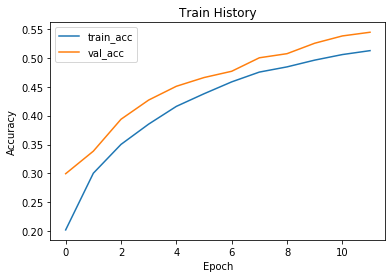

In [22]:
# 接著利用前面建立的函數把accuracy的結果畫出來
show_train_history('accuracy','val_accuracy')

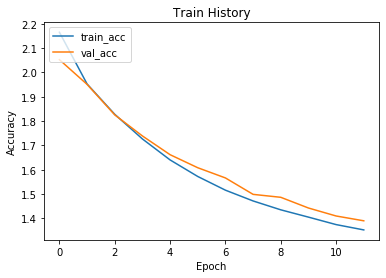

In [23]:
# 接著利用前面建立的函數把loss的結果畫出來
show_train_history('loss','val_loss')

In [27]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
                        epochs=12, batch_size=128, verbose=1)
'''
參數:
loss='categorical_crossentropy' : 設定損失函數，這邊使用cross entropy的效果比較好
optimizer='adam' :   使用adam為最優化方法
metrics=['accuracy'] 設定評估模型的方式是準確率
'''
train_history = model.fit(x_img_train_normalize, 
                          y_label_train_OneHot,
                          validation_split=0.25,
                          epochs=12,
                          batch_size=128,
                          verbose=2)
'''
參數:
epochs=12 : 設定跑12個訓練週期
batch_size=128 : 設定每一批次抓取128筆資料
verbose=2 : 設定顯示每一筆訓練過程
'''

# [validation_split = 0.2] validation_split：在0和1之間浮動。用作驗證數據的訓練數據的分數。
# 該模型將訓練數據的這一部分分開，不會對其進行訓練，並將在每個時期結束時評估該數據的損失和任何模型指標。
# [batch_size]：整數或None。每個梯度更新的樣本數。指定，batch_size為128

IndentationError: unexpected indent (<ipython-input-27-ad3dd9eacee0>, line 2)

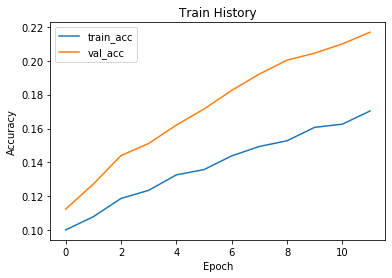

In [70]:
# 接著利用前面建立的函數把accuracy的結果畫出來
show_train_history('accuracy','val_accuracy')

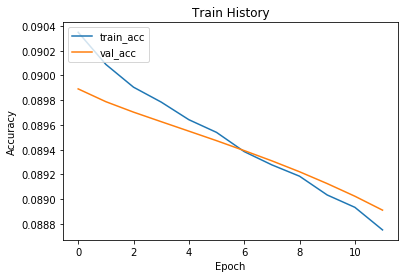

In [71]:
# 接著利用前面建立的函數把loss的結果畫出來
show_train_history('loss','val_loss')

In [113]:
model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy'])
                        
'''
參數:
loss='categorical_crossentropy' : 設定損失函數，這邊使用cross entropy的效果比較好
optimizer='adam' :   使用adam為最優化方法
metrics=['accuracy'] 設定評估模型的方式是準確率
'''
train_history = model.fit(x_img_train_normalize, y_label_train_OneHot,
                        validation_split=0.25,
                        epochs=12, batch_size=128, verbose=1)
'''
參數:
epochs=12 : 設定跑12個訓練週期
batch_size=128 : 設定每一批次抓取128筆資料
verbose=2 : 設定顯示每一筆訓練過程
'''

#[validation_split = 0.2] validation_split：在0和1之間浮動。用作驗證數據的訓練數據的分數。
#該模型將訓練數據的這一部分分開，不會對其進行訓練，並將在每個時期結束時評估該數據的損失和任何模型指標。
#[batch_size]：整數或None。每個梯度更新的樣本數。指定，batch_size為128

Train on 37500 samples, validate on 12500 samples
Epoch 1/12
37500/37500 [==============================] - 35s 927us/step - loss: 0.3254 - accuracy: 0.9000 - val_loss: 0.3224 - val_accuracy: 0.9000
Epoch 2/12
37500/37500 [==============================] - 34s 904us/step - loss: 0.3203 - accuracy: 0.9000 - val_loss: 0.3193 - val_accuracy: 0.9000
Epoch 3/12
37500/37500 [==============================] - 35s 921us/step - loss: 0.3152 - accuracy: 0.9000 - val_loss: 0.3151 - val_accuracy: 0.9000
Epoch 4/12
37500/37500 [==============================] - 34s 914us/step - loss: 0.3086 - accuracy: 0.9000 - val_loss: 0.3095 - val_accuracy: 0.9000
Epoch 5/12
37500/37500 [==============================] - 34s 919us/step - loss: 0.3023 - accuracy: 0.9000 - val_loss: 0.3041 - val_accuracy: 0.9000
Epoch 6/12
37500/37500 [==============================] - 35s 938us/step - loss: 0.2969 - accuracy: 0.9001 - val_loss: 0.2994 - val_accuracy: 0.9000
Epoch 7/12
37500/37500 [==============================] 

'\n參數:\nepochs=12 : 設定跑12個訓練週期\nbatch_size=128 : 設定每一批次抓取128筆資料\nverbose=2 : 設定顯示每一筆訓練過程\n'

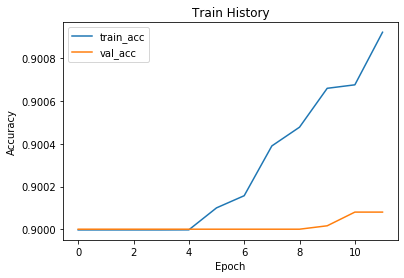

In [114]:
# 接著利用前面建立的函數把accuracy的結果畫出來
show_train_history('accuracy','val_accuracy')

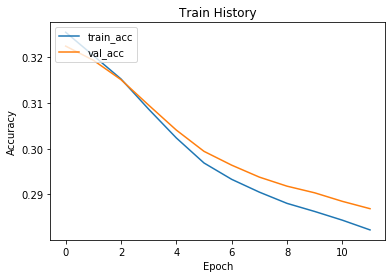

In [115]:
# 接著利用前面建立的函數把loss的結果畫出來
show_train_history('loss','val_loss')